# Part 1: Emulating the LSST DRP Source Catalog of blended systems with CosmoDC2Realizer

__Author:__ Ji Won Park (@jiwoncpark), __Created:__ 2018-12-14 (by @jiwoncpark), __Last Run:__ 2019-02-26 (by @jiwoncpark)

__Goals:__
- In Part 1 (this notebook), learn how CosmoDC2Realizer emulates the LSST DRP Source Catalog from galaxies in the CosmoDC2 extragalactic catalog and point sources in the truth catalog
- In Part 2 (next in this series), learn how SprinkledCosmoDC2Realizer emulates the LSST DRP Source Catalog by "sprinkling" lensed quasars from the OM10 catalog across the CosmoDC2 field, in the manner of the DC2 Sprinkler module.

The following notebook was referenced to access and query the truth catalog:

    Scott Daniel's DC2 Tutorial truth_gcr_intro.ipynb

In [1]:
import os, sys
import numpy as np
import pandas as pd 
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
# Utility functions for CosmoDC2Realizer
sys.path.insert(0, 'demo_utils')
import units
import moments
import cosmodc2realizer_helper as helper
# For reading in the OpSim database
#import sqlite3 (uncomment to run optional cells)
# For accessing and querying the CosmoDC2 extragalactic catalog and truth catalog
import GCRCatalogs
from GCR import GCRQuery
%matplotlib inline
%load_ext autoreload
%autoreload 2

## About CosmoDC2Realizer

`CosmoDC2Realizer` is a framework that emulates the LSST DRP Source Catalog. It takes in two DC2 catalogs--the extragalactic and truth catalogs, which contain properties of extended galaxy sources and point sources (e.g. stars, AGNs), respectively--and the OpSim database, which contains the per-visit observation conditions.

__Note on Dependencies:__

Although `CosmoDC2Realizer` is designed as a class within an LSSTDESC package called `SLRealizer`, we do not interface with the class in this notebook. The emphasis, instead, is to go over the logic of`CosmoDC2Realizer`. So we set aside some class helper modules in the directory `hackurdc2_utils` and use them directly.

`CosmoDC2Realizer` does explicitly loop over each blended system to generate the Source Catalog. But it makes heavy use of `NumPy` and `Pandas` to vectorize the moment calculation across the Gaussian components of the system, for an enhanced performance.

__Assumptions:__
- _Gaussian mixtures to allow analytical moment calculation._ Emulation is made fast by bypassing image generation; we model each object as a mixture of Gaussians and the point-spread function (PSF) as a circular Gaussian so that we can _analytically_ compute the first and second moments required to populate the Source Catalog. Because the galaxies in the extragalactic catalog are modeled as Sersic profiles (de Vaucouleurs bulge and exponential disk), we approximate each Sersic component as a mixture of Gaussians as introduced in Hogg and Lang 2013 (HL13).
- _A sufficiently good deblender._ We also assume a fairly good deblender with a fixed deblending scale of 0.5"--chosen because it roughly corresponds to the full-width half maximum (FWHM) of the best LSST seeing. All sources located within the line-of-sight deblending scale of an object for a given visit will contribute to the moments of that object. Such objects that become blended together are referred to as "neighbors" here.

## 1. Choosing the OpSim fields
The OpSim database is organized in terms of 5292 viewing fields generated from a tesselation of the sky ([OpSim catalog schema documentation](https://www.lsst.org/scientists/simulations/opsim/summary-table-column-descriptions-v335)). The observing schedule and conditions are the same within each field so, for computational efficiency, CosmoDC2Realizer first identifies the set of fields over which to realize the comprising objects.

I've downloaded and proprocessed all the OpSim data we'll need so running the cells with the comment `running optional` won't be necessary.

We are primarily interested in two tables of the `minion_1016` database: `ObsHistory` containing the observation conditions and `Field` containing the field positions.

`GCRCatalogs` has made available `cosmoDC2_v1.0_9556`, a test version of the extragalactic catalog restricted to one healpixel. This healpixel, it turns out, roughly coincides with the OpSim field with ID 1188. For speed considerations, we will only work with a small sample of galaxies in `cosmoDC2_v1.0_9556` that fall within Field 1188.

If the sampling position seems contrived, it is! I wanted to make sure to include a star-galaxy blend in our small sample.

In [2]:
# Our sampling position and range
field_id = 1188
sampling_ra, sampling_dec = 56.178028, -33.04581 # deg
sampling_radius = 0.05 # deg

## 2. Getting galaxies
We query the extragalactic catalog for objects that lie in this field. As mentioned earlier, we load `cosmoDC2_v1.0_9556` rather than the full cosmoDC2 catalog in this notebook for fast demonstration.

In [3]:
%%time
# Takes ~10s in Jupyter-dev
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.0_9556')
#catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.0_image') # the whole image area
quantities = ['galaxy_id', 'ra_true', 'dec_true', 'redshift_true', 
              'size_bulge_true', 'size_minor_bulge_true', 'sersic_bulge', 'ellipticity_1_bulge_true',
              'ellipticity_2_bulge_true', 'ellipticity_bulge_true',
              'size_disk_true', 'size_minor_disk_true', 'sersic_disk', 'ellipticity_1_disk_true',
              'ellipticity_2_disk_true', 'ellipticity_disk_true',
              'bulge_to_total_ratio_i',
              'mag_true_u_lsst',
              'mag_true_g_lsst',
              'mag_true_r_lsst',
              'mag_true_i_lsst',
              'mag_true_z_lsst',
              'mag_true_Y_lsst',
              'halo_mass',]

cuts = [# Magnitude cut at 5-sigma depth for single exposure
        # See https://confluence.lsstcorp.org/display/LKB/LSST+Key+Numbers
        GCRQuery('mag_true_i_lsst < 24'), 
        # Query halo masses likely to host an AGN
        GCRQuery('halo_mass > 1.e13'),
        # Query sources located in Field 1188
        GCRQuery('((ra_true - %f)**2.0 + (dec_true - %f)**2.0)**0.5 < %f' %(sampling_ra, sampling_dec, sampling_radius)),
        #GCRQuery('abs(dec_true - %f) < %f' %(field_dec, field_radius)),
        ]
# Add filters as necessary!
galaxies = catalog.get_quantities(quantities, filters=cuts)
galaxies = pd.DataFrame(galaxies)

CPU times: user 3.86 s, sys: 1.34 s, total: 5.2 s
Wall time: 9.96 s


## 3. Getting line-of-sight neighbors
For each galaxy, any other galaxy or point source (unlensed AGN or star) that lie within its blending scale will be its line-of-sight neighbor. Galaxy neighbors will simply be taken from the extragalactic catalog, which we've already fetched. Point-source neighbors will be taken from the truth catalog as below.

### Getting the neighbors (unlensed AGNs and stars) from the truth catalog

In [4]:
%%time
# Takes ~1min in Jupyter-dev
# truth_catalog = GCRCatalogs.load_catalog('dc2_truth_run1.1_static')
truth_catalog = GCRCatalogs.load_catalog('dc2_truth_run1.1', {'md5': None})

truth_catalog_columns = ['object_id', 'ra', 'dec', 'star', 'agn', 'sprinkled', 'healpix_2048',
                        'u', 'g', 'r', 'i', 'z', 'y',]
# ~40 in Jupyter-dev
cuts = ['(star==1) | (agn==1)', # either a star or unlensed AGN
        'sprinkled==0', # but not a lensed AGN
        '((ra - %f)**2.0 + (dec - %f)**2.0)**0.5 < %f' %(sampling_ra, sampling_dec, sampling_radius),
       ]

# around 15s on Jupyter-dev
point_neighbors = truth_catalog.get_quantities(truth_catalog_columns, filters=cuts)
point_neighbors = pd.DataFrame(point_neighbors)

CPU times: user 48.3 s, sys: 3.7 s, total: 52 s
Wall time: 52.5 s


In [5]:
# Some config constants to define before entering loop
deblending_scale = 0.5 # arcsec
fov = units.deg_to_arcsec(1.75) # arcsec

Before entering the source catalog generation loop, we format the catalogs we fetched.

In [6]:
# Some unit conversion and column renaming
galaxies = helper._format_extragal_catalog(galaxies)
point_neighbors = helper._format_truth_catalog(point_neighbors)

... and also read in the preformatted OpSim tables.

In [7]:
# Read in pre-formatted OpSim tables
# Their paths
field_path = '/global/homes/j/jwp/SLRealizer/slrealizer/demo/demo_data/field.csv'
obs_history_path = '/global/homes/j/jwp/SLRealizer/slrealizer/demo/demo_data/obs_history.csv'
# Pre-formatted using these lines
#field = field.to_csv(field_path, index=False)
#obs_history = helper._format_obs_history(obs_history, field, obs_history_path)
# Read them in
field = pd.read_csv(field_path, index_col=None)
obs_history = pd.read_csv(obs_history_path, index_col=None)

Now we generate the Source catalog, system by system. This loop has much room for optimization, but should be most readable as is! Note that you can add more sampling positions (pointings) by appending to the `pointings` list.

In [8]:
%%time
# Takes ~2min in Jupyter-dev
source_cols = ['objectId', 'ccdVisitId', 
               'apFlux', 'Ix', 'Iy', 'Ixx', 'Iyy', 'Ixy', 
               'Ixx_PSF', 'sky', 'apFluxErr', 'expMJD',
               'num_star_neighbors', 'num_agn_neighbors', 'num_sprinkled_neighbors']

# Empty source table to be populated
source = pd.DataFrame(columns=source_cols)

# List of [ra, dec] pointings
pointings = [[units.deg_to_arcsec(sampling_ra), units.deg_to_arcsec(sampling_dec)],]
for pointing in pointings:
    pointing_ra, pointing_dec = pointing
    # Note: Much of the field querying is redundant to what we did in advance
    # in this notebook, outside the loop.
    # Query extragalactic catalog for galaxies within field
    galaxies_in_fov, galaxies_in_fov_idx = helper.get_neighbors(galaxies, pointing_ra, pointing_dec, fov)
    num_galaxies = len(galaxies_in_fov_idx)
    # Query truth catalog for stars/AGNs within field
    points_in_fov, _ = helper.get_neighbors(point_neighbors, pointing_ra, pointing_dec, fov)
    # Initialize DataFrame to populate before joining with obs_history_in_field
    source_at_pointing = pd.DataFrame(columns=source_cols)
    
    for gal_idx in range(num_galaxies):
        # Central galaxy
        central_gal = galaxies_in_fov.iloc[gal_idx]
        ra_center, dec_center = central_gal['ra'], central_gal['dec'] # pos of central galaxy
        
        ##########################
        # Find blended neighbors #
        ##########################
        # Galaxy neighbors (extended) : includes the central galaxy, not just neighbors
        all_gal, all_gal_idx = helper.get_neighbors(galaxies_in_fov, ra_center, dec_center, deblending_scale) 
        num_gal_neighbors = len(all_gal_idx) - 1 # subtract central galaxy itself
        # Stars/AGN neighbors (point)
        point, point_idx = helper.get_neighbors(points_in_fov, ra_center, dec_center, deblending_scale) 
        
        num_star_neighbors = point['star'].sum()
        num_agn_neighbors = point['agn'].sum()
        num_sprinkled_neighbors = point['sprinkled'].sum()
        
        #################
        # Sersic to MoG #
        #################
        # Separate galaxy catalog into bulge and disk
        bulge, disk, all_gal = helper.separate_bulge_disk(all_gal)
        # Deconstruct bulge/disk into MoG
        bulge_mog = helper.sersic_to_mog(sersic_df=bulge, bulge_or_disk='bulge')
        disk_mog = helper.sersic_to_mog(sersic_df=disk, bulge_or_disk='disk')
        point_mog = helper.point_to_mog(point_df=point)
        # Concat the three
        full_mog = pd.concat([bulge_mog, disk_mog, point_mog], axis=0)

        # Add some metadata
        full_mog['objectId'] = central_gal['galaxy_id'] # identifier for blended system
        full_mog['num_gal_neighbors'] = num_gal_neighbors
        full_mog['num_star_neighbors'] = num_star_neighbors
        full_mog['num_agn_neighbors'] = num_agn_neighbors
        full_mog['num_sprinkled_neighbors'] = num_sprinkled_neighbors

        # Get visits at the system's position
        obs_sys_center, _ = helper.get_neighbors(obs_history, ra_center, dec_center, fov, 'ditheredRA', 'ditheredDec')
        # Join with observations
        mog_observed = helper.join_with_observation(full_mog, obs_sys_center)
        # Remove unobserved fluxes (only keep flux of observed filter)
        mog_observed = helper.collapse_unobserved_fluxes(mog_observed)
        # Calculate moment contribution of each Gaussian of blended system
        mog_observed = moments.calculate_total_flux(mog_observed)
        mog_observed = moments.calculate_1st_moments(mog_observed)
        mog_observed = moments.calculate_2nd_moments(mog_observed)
        # Collapse MoGs into one blended system
        blended = moments.collapse_mog(mog_observed)
        blended = moments.apply_environment(blended)

        source_at_pointing = pd.concat([source_at_pointing, blended], axis=0, sort=True)
        if (gal_idx + 1) %20 == 0:
            print("%d systems completed" %(gal_idx + 1))

    source = pd.concat([source, source_at_pointing], axis=0, sort=True)
    source = helper.typecast_source(source)

CPU times: user 11.9 s, sys: 303 ms, total: 12.2 s
Wall time: 12.2 s


Let's first visualize which where our galaxies and point sources lie.

Text(0.5,1,'Pre-blended positions of our objects')

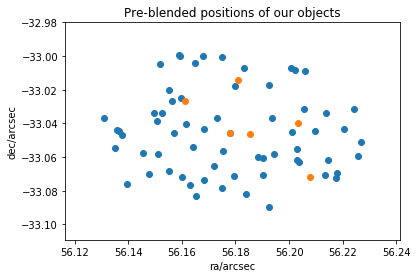

In [9]:
plt.scatter(units.arcsec_to_deg(point_neighbors['ra'].values),
            units.arcsec_to_deg(point_neighbors['dec'].values), label='point source')
plt.scatter(units.arcsec_to_deg(galaxies['ra'].values), 
            units.arcsec_to_deg(galaxies['dec'].values), label='galaxy')
plt.ylabel("dec/arcsec")
plt.xlabel("ra/arcsec")
plt.title("Pre-blended positions of our objects")

Here are sample light curves of a blended system consisting of a galaxy and a star.

In [10]:
# Add a 'filter' column to the Source Catalog by joining with the obs_history table
obs_history_filter = obs_history[['ccdVisitId', 'filter']].copy()
source = pd.merge(source, obs_history_filter, on='ccdVisitId', how='left')

In [11]:
# Choose a random system with a star and galaxy blended together.
sample_id = source.loc[source['num_star_neighbors']==1]['objectId'].unique()[0]
sample_info = source.loc[source['objectId']==sample_id]

To compare the light curves of the blended system with the individual galaxy and star, we realize them separately.

In [12]:
# Realize the galaxy by itself
galaxy_alone = helper.realize_all_visits_single_object(target_object_id=sample_id, is_galaxy=True, 
                                                       fov=fov, deblending_scale=deblending_scale,
                                                       galaxies_df=galaxies, points_df=point_neighbors, obs_history=obs_history)
galaxy_alone['ccdVisitId'] = galaxy_alone['ccdVisitId'].astype(int)
galaxy_alone = pd.merge(galaxy_alone, obs_history_filter, on='ccdVisitId', how='left')

# Realize the star by itself
star_alone = helper.realize_all_visits_single_object(target_object_id=sample_id, is_galaxy=False, 
                                              fov=fov, deblending_scale=deblending_scale,
                                              galaxies_df=galaxies, points_df=point_neighbors, obs_history=obs_history)
star_alone['ccdVisitId'] = star_alone['ccdVisitId'].astype(int)
star_alone = pd.merge(star_alone, obs_history_filter, on='ccdVisitId', how='left')

demo_utils/units.py:7: RuntimeWarning: invalid value encountered in log10
  return zeropoint_mag - 2.5*np.log10(flux)


Text(0.5,1,'Light curves of unblended star and galaxy')

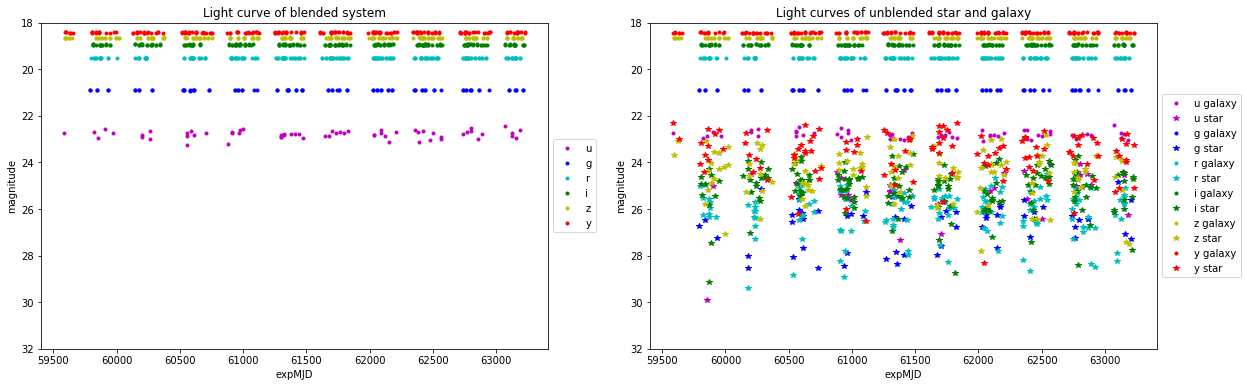

In [13]:
# Plot light curve
color_dict = {'u': 'm', 'g': 'b', 'r': 'c', 'i': 'g', 'z': 'y', 'y': 'r'}

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
for bp in 'ugrizy':
    # Blended
    times = sample_info.loc[sample_info['filter']==bp]['expMJD'].values
    fluxes = sample_info.loc[sample_info['filter']==bp]['apFlux'].values
    mags = units.flux_to_mag(fluxes, from_unit='nMgy')
    plt.plot(times, mags, color_dict[bp] + '.', label=bp)

ax = plt.gca()
ax.invert_yaxis()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('magnitude')
plt.ylim([32, 18])
plt.xlabel('expMJD')
plt.title("Light curve of blended system")

fig.add_subplot(1,2,2)
for bp in 'ugrizy':
    times = sample_info.loc[sample_info['filter']==bp]['expMJD'].values
    # Galaxy
    gal_fluxes = galaxy_alone.loc[galaxy_alone['filter']==bp]['apFlux'].values
    gal_mags = units.flux_to_mag(gal_fluxes, from_unit='nMgy')
    plt.plot(times, gal_mags, color_dict[bp] + '.', label=bp+' galaxy')
    # Star
    star_fluxes = star_alone.loc[star_alone['filter']==bp]['apFlux'].values
    star_mags = units.flux_to_mag(star_fluxes, from_unit='nMgy')
    plt.plot(times, star_mags, color_dict[bp] + '*', label=bp+' star')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('magnitude')
plt.ylim([32, 18])
plt.xlabel('expMJD')
plt.title("Light curves of unblended star and galaxy")

Similarly, we can plot the size curves!

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,1,'Size curves of unblended star and galaxy')

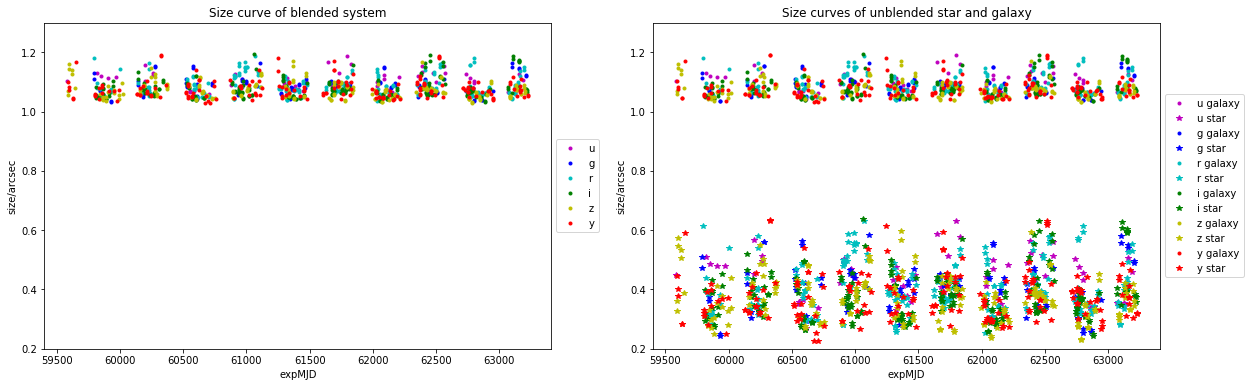

In [17]:
# Plot size curve

def add_size(df):
    """Compute size ~ (det)^0.25 where det = Ixx*Iyy - Ixy**2.0
    and add as a new column in the df
    """
    df['size'] = (df['Ixx'].values*df['Iyy'].values - df['Ixy'].values**2.0)**0.25
    return df

sample_info = add_size(sample_info)
galaxy_alone = add_size(galaxy_alone)
star_alone = add_size(star_alone)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
for bp in 'ugrizy':
    # Blended
    times = sample_info.loc[sample_info['filter']==bp]['expMJD'].values
    sizes = sample_info.loc[sample_info['filter']==bp]['size'].values
    plt.plot(times, sizes, color_dict[bp] + '.', label=bp)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('size/arcsec')
plt.ylim([0.2, 1.3])
plt.xlabel('expMJD')
plt.title("Size curve of blended system")

fig.add_subplot(1,2,2)
for bp in 'ugrizy':
    times = sample_info.loc[sample_info['filter']==bp]['expMJD'].values
    # Galaxy
    gal_sizes = galaxy_alone.loc[galaxy_alone['filter']==bp]['size'].values
    plt.plot(times, gal_sizes, color_dict[bp] + '.', label=bp+' galaxy')
    # Star
    star_sizes = star_alone.loc[star_alone['filter']==bp]['size'].values
    plt.plot(times, star_sizes, color_dict[bp] + '*', label=bp+' star')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('size/arcsec')
plt.ylim([0.2, 1.3])
plt.xlabel('expMJD')
plt.title("Size curves of unblended star and galaxy")

Lastly, let's take a look at the first few rows of our emulated Source catalog.

In [15]:
display(source.head())

,Ix,Ixx,Ixx_PSF,Ixy,Iy,Iyy,apFlux,apFluxErr,ccdVisitId,expMJD,num_agn_neighbors,num_gal_neighbors,num_sprinkled_neighbors,num_star_neighbors,objectId,sky,filter
0,56.1854,31.187494,0.201040,-2.405681,-33.046327,29.816771,3.231181,0.098030,2340,59583.123341,0,0,0,0,4000697468,22.197691,u
1,56.1854,31.185923,0.199470,-2.405681,-33.046327,29.815201,157.376523,0.602330,5767,59588.039067,0,0,0,0,4000697468,17.000000,y
2,56.1854,31.093178,0.106724,-2.405681,-33.046327,29.722455,128.430943,0.157892,8004,59591.084162,0,0,0,0,4000697468,18.321369,z
3,56.1854,31.117262,0.130809,-2.405681,-33.046327,29.746540,128.374918,0.176510,8046,59591.105687,0,0,0,0,4000697468,18.305078,z
4,56.1854,31.148499,0.162045,-2.405681,-33.046327,29.777777,156.955325,0.477653,12455,59597.083856,0,0,0,0,4000697468,17.300000,y
